<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/lpips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.1 MB/s eta 0:00:00


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


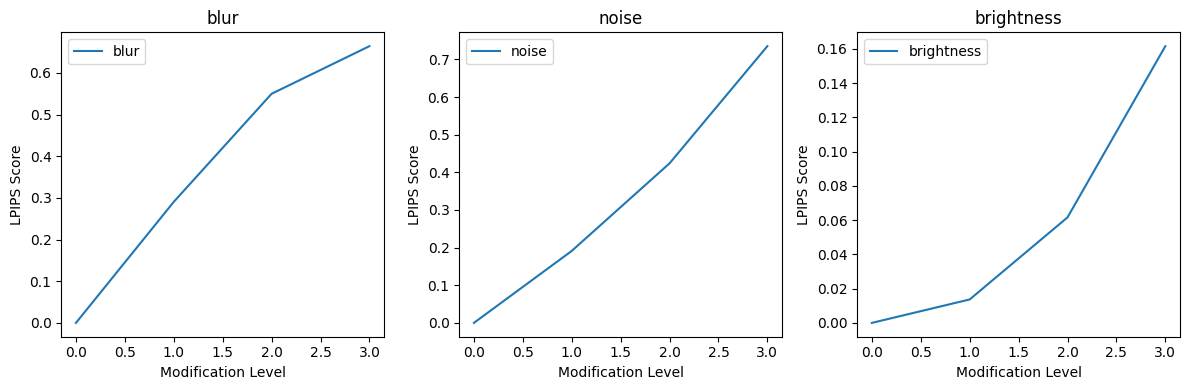

In [ ]:
import torch
import lpips
import numpy as np
from PIL import Image, ImageFilter, ImageEnhance
from torchvision import transforms
from matplotlib import pyplot as plt
from skimage import data

def preprocess_image(img):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)  # Add batch dimension

# Load an example image from skimage
base_img = data.astronaut()  # Example RGB image
base_img = Image.fromarray(base_img)

# Preprocess base image
base_img_tensor = preprocess_image(base_img)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex')  # Using AlexNet

# Modification levels
blur_levels = [0, 2, 5, 10]  # Gaussian blur radius
noise_levels = [0, 0.05, 0.1, 0.2]  # Noise intensity
brightness_levels = [1, 0.8, 0.6, 0.4]  # Brightness factor

lpips_scores = {'blur': [], 'noise': [], 'brightness': []}

# Compute LPIPS for different modifications
for blur in blur_levels:
    modified_img = base_img.filter(ImageFilter.GaussianBlur(blur))
    lpips_scores['blur'].append(lpips_model(base_img_tensor, preprocess_image(modified_img)).item())

for noise in noise_levels:
    noise_img = np.array(base_img).astype(np.float32)
    noise_img += np.random.normal(scale=noise * 255, size=noise_img.shape)
    noise_img = np.clip(noise_img, 0, 255).astype(np.uint8)
    lpips_scores['noise'].append(lpips_model(base_img_tensor, preprocess_image(Image.fromarray(noise_img))).item())

for brightness in brightness_levels:
    enhancer = ImageEnhance.Brightness(base_img)
    modified_img = enhancer.enhance(brightness)
    lpips_scores['brightness'].append(lpips_model(base_img_tensor, preprocess_image(modified_img)).item())

# Plotting results
plt.figure(figsize=(12, 4))
for i, (mod_type, scores) in enumerate(lpips_scores.items()):
    plt.subplot(1, 3, i+1)
    plt.plot(scores, label=mod_type)
    plt.title(mod_type)
    plt.xlabel('Modification Level')
    plt.ylabel('LPIPS Score')
    plt.legend()
plt.tight_layout()
plt.show()


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


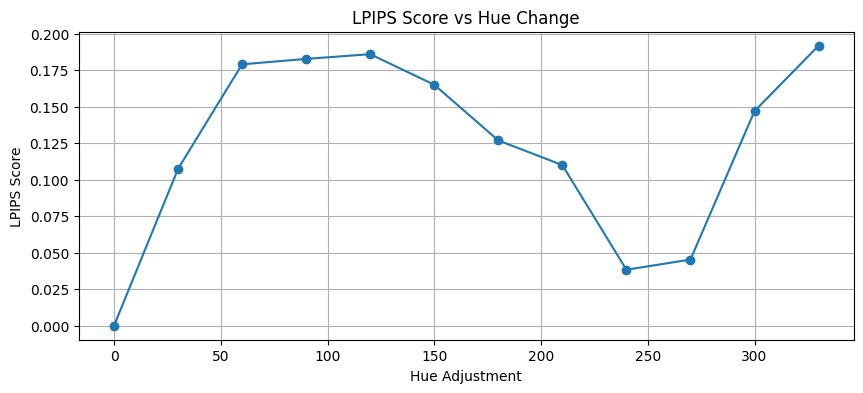

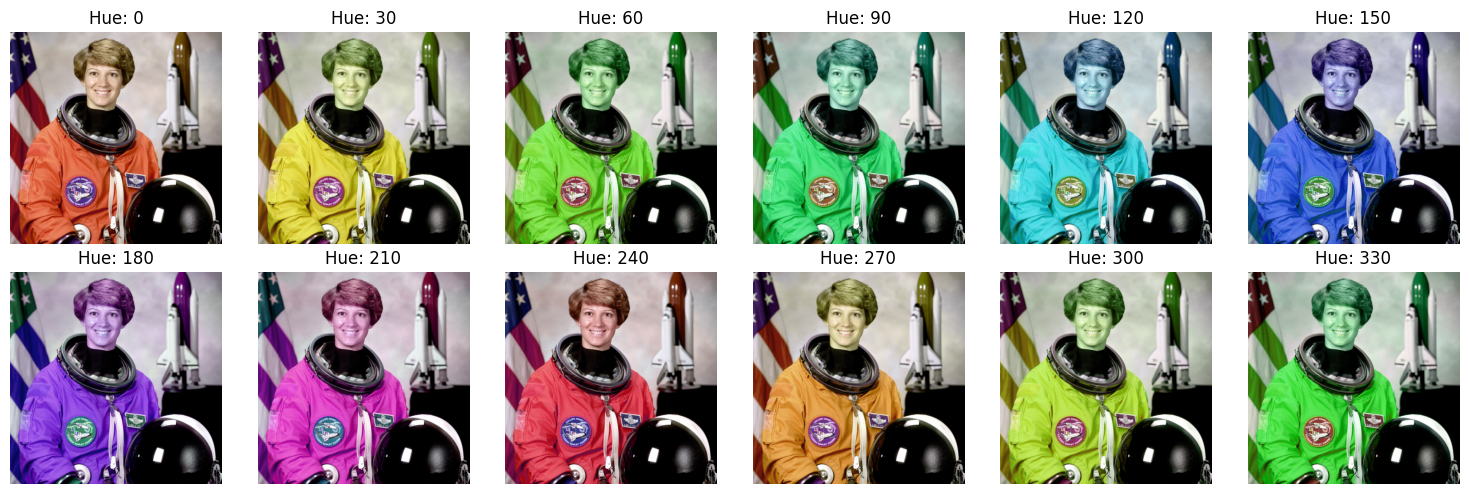

In [ ]:
import torch
import lpips
import numpy as np
import colorsys
from PIL import Image, ImageEnhance
from torchvision import transforms
from matplotlib import pyplot as plt
from skimage import data

def preprocess_image(img):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)  # Add batch dimension

def adjust_hue(img, hue_factor):
    img = img.convert('HSV')
    np_img = np.array(img)
    np_img[..., 0] = np_img[..., 0] + hue_factor
    np_img[..., 0] = np_img[..., 0] % 256
    img = Image.fromarray(np_img, 'HSV')
    return img.convert('RGB')

# Load an example image from skimage
base_img = data.astronaut()  # Example RGB image
base_img = Image.fromarray(base_img)

# Preprocess base image
base_img_tensor = preprocess_image(base_img)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex')  # Using AlexNet

# Hue modification levels
hue_levels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

lpips_scores = []
generated_images = []

# Compute LPIPS for different hue modifications
for hue in hue_levels:
    modified_img = adjust_hue(base_img, hue)
    lpips_scores.append(lpips_model(base_img_tensor, preprocess_image(modified_img)).item())
    generated_images.append(modified_img)

# Plotting results
plt.figure(figsize=(10, 4))
plt.plot(hue_levels, lpips_scores, marker='o')
plt.title('LPIPS Score vs Hue Change')
plt.xlabel('Hue Adjustment')
plt.ylabel('LPIPS Score')
plt.grid(True)
plt.show()

# Display example images
plt.figure(figsize=(15, 5))
for i, img in enumerate(generated_images):
    plt.subplot(2, 6, i+1)
    plt.imshow(img)
    plt.title(f'Hue: {hue_levels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.6 MB/s eta 0:00:00


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 66.9MB/s]


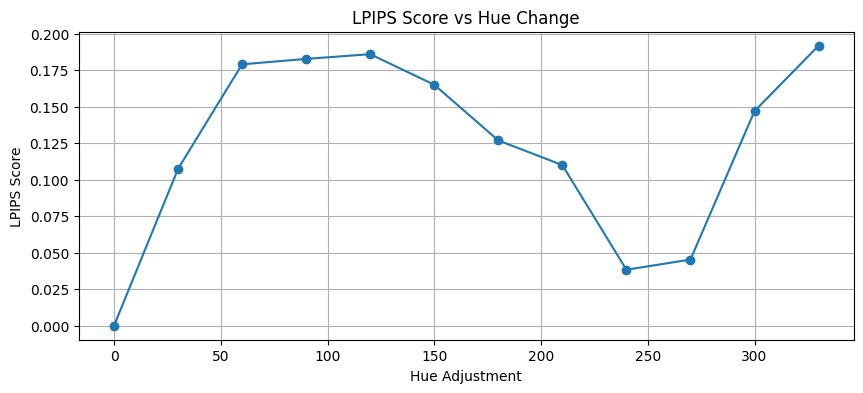

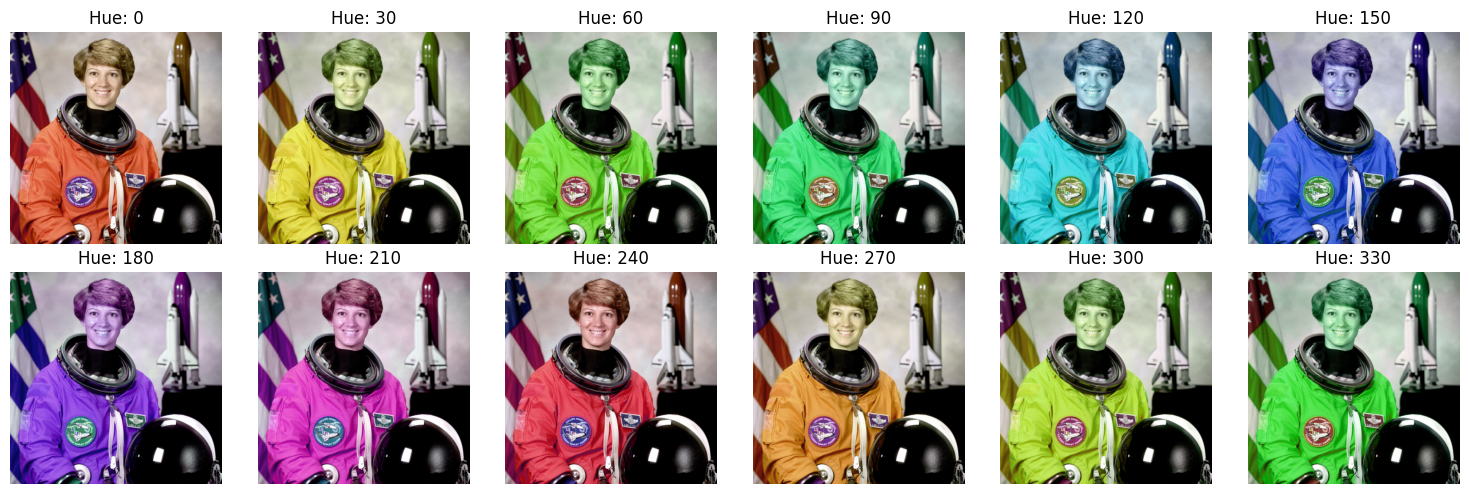

In [3]:
import torch
import numpy as np
import colorsys
from PIL import Image, ImageEnhance
from torchvision import transforms
from matplotlib import pyplot as plt
from skimage import data
import torchmetrics

def preprocess_image(img):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)  # Add batch dimension

def adjust_hue(img, hue_factor):
    img = img.convert('HSV')
    np_img = np.array(img)
    np_img[..., 0] = np_img[..., 0] + hue_factor
    np_img[..., 0] = np_img[..., 0] % 256
    img = Image.fromarray(np_img, 'HSV')
    return img.convert('RGB')

# Load an example image from skimage
base_img = data.astronaut()  # Example RGB image
base_img = Image.fromarray(base_img)

# Preprocess base image
base_img_tensor = preprocess_image(base_img)

# LPIPS model
lpips_model = torchmetrics.image.lpip.LearnedPerceptualImagePatchSimilarity(net_type='alex')

# Hue modification levels
hue_levels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

lpips_scores = []
generated_images = []

# Compute LPIPS for different hue modifications
for hue in hue_levels:
    modified_img = adjust_hue(base_img, hue)
    modified_img_tensor = preprocess_image(modified_img)
    lpips_score = lpips_model(base_img_tensor, modified_img_tensor)
    lpips_scores.append(lpips_score.item())
    generated_images.append(modified_img)

# Plotting results
plt.figure(figsize=(10, 4))
plt.plot(hue_levels, lpips_scores, marker='o')
plt.title('LPIPS Score vs Hue Change')
plt.xlabel('Hue Adjustment')
plt.ylabel('LPIPS Score')
plt.grid(True)
plt.show()

# Display example images
plt.figure(figsize=(15, 5))
for i, img in enumerate(generated_images):
    plt.subplot(2, 6, i+1)
    plt.imshow(img)
    plt.title(f'Hue: {hue_levels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


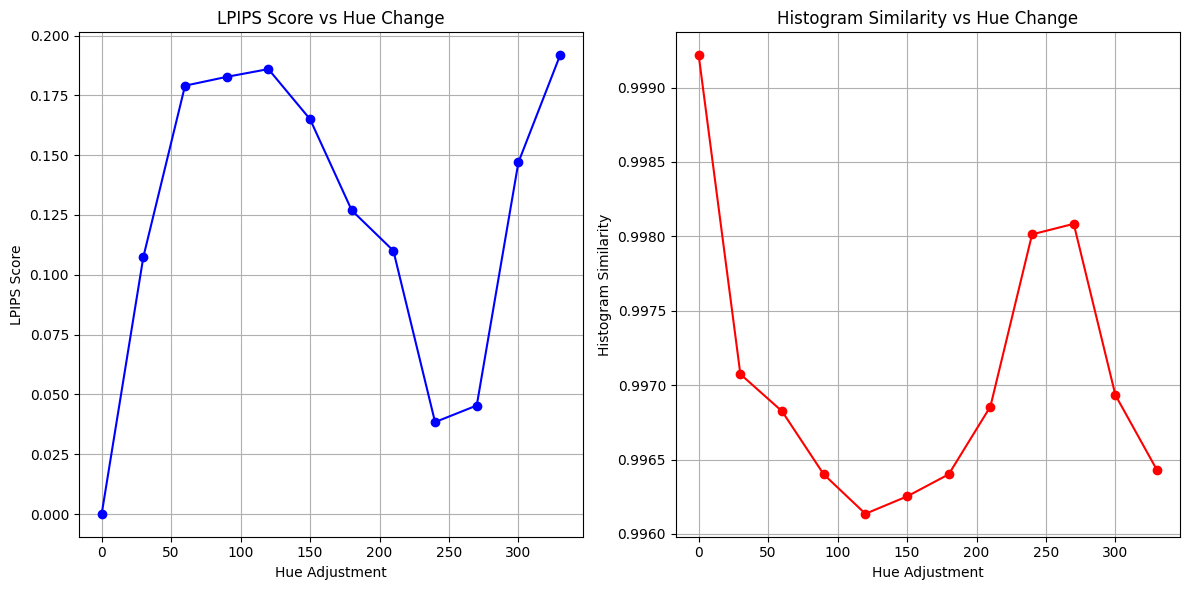

In [4]:
import torch
import numpy as np
import cv2
from PIL import Image, ImageEnhance
from torchvision import transforms
from matplotlib import pyplot as plt
from skimage import data
import torchmetrics

def preprocess_image(img):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)  # Add batch dimension

def adjust_hue(img, hue_factor):
    img = img.convert('HSV')
    np_img = np.array(img)
    np_img[..., 0] = np_img[..., 0] + hue_factor
    np_img[..., 0] = np_img[..., 0] % 256
    img = Image.fromarray(np_img, 'HSV')
    return img.convert('RGB')

def calculate_histogram_similarity(img1, img2):
    # Convert images to HSV and calculate histograms
    hist1 = cv2.calcHist([img1], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    hist2 = cv2.calcHist([img2], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    # Normalize and compare histograms
    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()
    similarity = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return similarity

# Load an example image from skimage
base_img = data.astronaut()  # Example RGB image
base_img_pil = Image.fromarray(base_img)
base_img_cv = cv2.cvtColor(base_img, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

# Preprocess base image
base_img_tensor = preprocess_image(base_img_pil)

# LPIPS model
lpips_model = torchmetrics.image.lpip.LearnedPerceptualImagePatchSimilarity(net_type='alex')

# Hue modification levels
hue_levels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

lpips_scores = []
histogram_similarities = []

# Compute LPIPS and Histogram Similarity for different hue modifications
for hue in hue_levels:
    modified_img_pil = adjust_hue(base_img_pil, hue)
    modified_img_cv = cv2.cvtColor(np.array(modified_img_pil), cv2.COLOR_RGB2BGR)
    modified_img_tensor = preprocess_image(modified_img_pil)

    lpips_score = lpips_model(base_img_tensor, modified_img_tensor)
    lpips_scores.append(lpips_score.item())

    histogram_similarity = calculate_histogram_similarity(base_img_cv, modified_img_cv)
    histogram_similarities.append(histogram_similarity)

# Plotting results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hue_levels, lpips_scores, marker='o', color='blue', label='LPIPS')
plt.title('LPIPS Score vs Hue Change')
plt.xlabel('Hue Adjustment')
plt.ylabel('LPIPS Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hue_levels, histogram_similarities, marker='o', color='red', label='Histogram Similarity')
plt.title('Histogram Similarity vs Hue Change')
plt.xlabel('Hue Adjustment')
plt.ylabel('Histogram Similarity')
plt.grid(True)

plt.tight_layout()
plt.show()
